In [1]:
# Importing necessary packages and libraries

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import os
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
# resized
!wget https://github.com/dlops-io/datasets/releases/download/v1.0/resized_lecture18.zip
!unzip -qq resized_lecture18.zip

--2025-10-22 11:20:49--  https://github.com/dlops-io/datasets/releases/download/v1.0/resized_lecture18.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/394736489/665dcbe3-6ec4-4d56-975d-626c41fa888e?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-22T12%3A02%3A24Z&rscd=attachment%3B+filename%3Dresized_lecture18.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-22T11%3A01%3A54Z&ske=2025-10-22T12%3A02%3A24Z&sks=b&skv=2018-11-09&sig=IYacQeZidVy6yfKgGeqQwx7NzqWEnaE9tXJ9c1w0XjU%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MTEzMzg0OSwibmJmIjoxNzYxMTMyMDQ5LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdG

In [3]:
DATA_DIR = '.'

[QUIZ QUESTION 9]
### ⏸ If you were to build a custom classifier using Transfer Learning, which pre-trained model would you use:
#### A. VGG16 model trained on medical images
#### B. MobileNet model trained on ImageNet
#### C. InceptionNet model trained on Landscape images



## Get dataset

In [4]:
# Path of image data
# data_path = os.path.join(DATA_DIR, 'images/train')
data_path = os.path.join(DATA_DIR, 'resized_lecture18/train')


# Use the `ImageDataGenerator` function from keras to generate new images based on our existing ones
# Mention the preprocessing function as mobilenet's preprocess_input and specify a validation split of 20%
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

# Build your train_generator by specifying the directory using the data_path variable defined above
# Mention target size, color mode, batch_size, subset as 'training' and shuffle = True
train_generator=train_datagen.flow_from_directory(data_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True)

# Build your validation_generator similar to the previous step
# Specifying using the data_path variable defined above with subset as 'validation'
validation_generator=train_datagen.train_generator=train_datagen.flow_from_directory(data_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False)

Found 1252 images belonging to 2 classes.
Found 312 images belonging to 2 classes.


## Mobilenet plug and play

Lets now use MobileNet as it is quite lightweight (17Mb), freeze the base layers and lets add and train the top few layers. Note only two classifiers.

In [5]:
# Use the mobilenet architecture as a starting point for our base model

# Import the mobilenet model with pre-trained imagenet weights, input_shape
# Discard the last 1000 neuron layer ie. the final fully connected layer
base_model=MobileNet(weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [7]:

x=base_model.output

x=GlobalAveragePooling2D()(x)

# On top of mobile net, add a few dense layers with 'relu' activation

# Using functional API, add a dense layer with 1024 neurons
x=Dense(1024, 'relu')(x)

# Add a dense layer with 512 neurons
x=Dense(512, 'relu')(x)

# Add a final layer with 2 neurons and softmax activation
preds=Dense(2, activation='softmax')(x)

In [8]:
# Using the functional API of keras, specify the input from the base model and the output as `preds` described above

model = Model(inputs=base_model.input, outputs=preds) #specify the inputs and outputs


[QUIZ QUESTION 10]
### ⏸ When you used the pre-trained model in the exercise, did you use the entire pre-trained model (convolution layers and classification dense layers) with all the layers?
#### A. True
#### B. False

In [9]:
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer1 = 'B'

We will use pre-trained weights as the model has been trained already on the Imagenet dataset. We ensure all the weights are non-trainable. We will only train the last few dense layers.

In [10]:
# For transfer learning, we need to freeze some layers. Below we freeze the first 10 layers

# Freeze the first 10 layers of the network to be non-trainable

for layer in model.layers[:10]:
    layer.trainable = False


Lets check the model architecture

In [11]:
# Look at the summary of your model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,804,290 (18.33 MB)

 Trainable params: 4,778,946 (18.23 MB)

 Non-trainable params: 25,344 (99.00 KB)

### ⏸ The pre trained model from the exercise has 3206976 trainable parameters. After having done your modifications, this number of parameters changes to how many trainable parameters ? (please do not enter commas or decimals in the quiz answer, just integer)

In [12]:
# Submit an answer as e.g. 10000 (no commas or decimals)
answer3 = '4778946'

Now lets load the training data into the ImageDataGenerator. Specify path, and it automatically sends the data for training in batches, simplifying the code.

Compile the model. Now lets train it. Should take less than two minutes on a GTX1070 GPU.

## Training the model

In [13]:
# We now train our model, but first we will compile it with an appropriate loss function and optimizer

# Adam optimizer
# loss function will be categorical crossentropy
# evaluation metric will be accuracy

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Fit the model using the step size for train and validation specified below
# Given the limited resources, please restrict the number of epochs to less than 5

step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=validation_generator.n//validation_generator.batch_size

model.fit(
    train_generator,
    steps_per_epoch=step_size_train,
    validation_data=validation_generator,
    validation_steps=step_size_validation,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 58s 656ms/step - accuracy: 0.6968 - loss: 0.5307 - val_accuracy: 0.9062 - val_loss: 0.2183
Epoch 2/5
 1/39 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 0.1107

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.1107 - val_accuracy: 0.9097 - val_loss: 0.2165
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9797 - loss: 0.0823 - val_accuracy: 0.9375 - val_loss: 0.1733
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0890 - val_accuracy: 0.9340 - val_loss: 0.1809
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9885 - loss: 0.0406 - val_accuracy: 0.8889 - val_loss: 0.2728


Model is now trained. Now lets test some independent input images to check the predictions.

## Inference on unseen data

In [15]:
# A helper function that takes a standard image and converts it into a tensor that can be used by the model

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor = preprocess_input(img_tensor)               # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

In [16]:
# We specify the paths of the six images
# First set of images
img_path1 = os.path.join(DATA_DIR, 'resized_lecture18/test/31.jpg')
img_path2 = os.path.join(DATA_DIR, 'resized_lecture18/test/458.jpg')
img_path3 = os.path.join(DATA_DIR, 'resized_lecture18/test/571.jpg')


# Second set of images
img_path4 = os.path.join(DATA_DIR, 'resized_lecture18/test/rashmi.jpg')
img_path5 = os.path.join(DATA_DIR, 'resized_lecture18/test/pavlos.jpg')
img_path6 = os.path.join(DATA_DIR, 'resized_lecture18/test/shivas.jpg')


In [17]:
# Helper function that nicely predicts the class along with the input image

def prediction(img_loc,ax):
    new_image = load_image(img_loc)
    pred = model.predict(new_image)
    classmap = {v:k for k,v in (train_generator.class_indices).items()}
    plot_img = mpimg.imread(img_loc);
    ax.imshow(plot_img, vmin=0, vmax=255)
    ax.set_title(f'Prediction: {classmap[pred.argmax(-1)[0]]} \n (with confidence: {str(pred[0][pred.argmax(-1)][0])[:4]})'  ,fontsize=12)
    ax.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


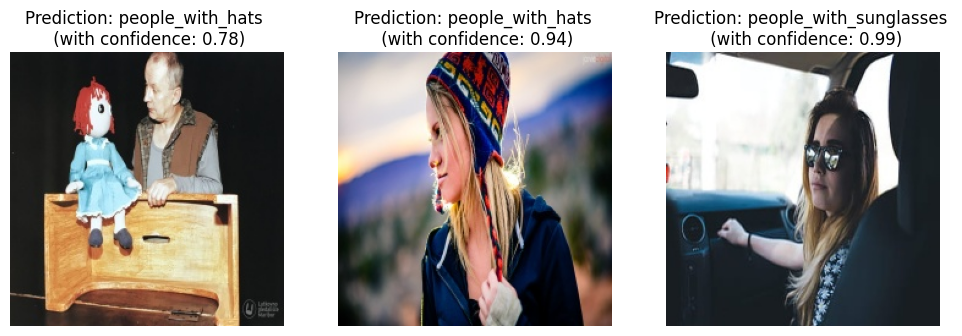

In [20]:
 # Make predictions on first set of images defined above that were never shown to the model before
fig, axes = plt.subplots(1,3,figsize=(12,6))

# Call the prediction function defined above for this
# For each prediction mention the axes
prediction(img_path1, axes[0])
prediction(img_path2, axes[1])
prediction(img_path3, axes[2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


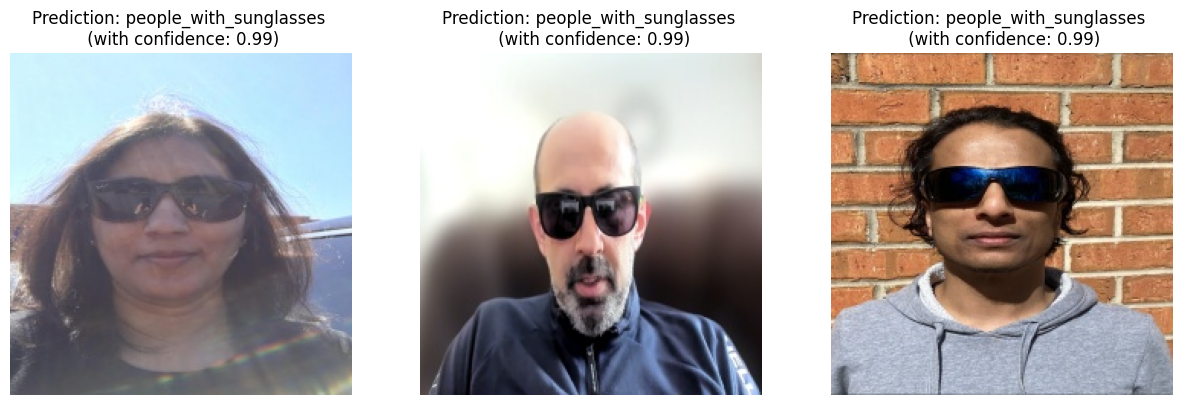

In [21]:
# Make predictions on second set of images defined above that were never shown to the model before
fig, axes = plt.subplots(1,3,figsize=(15,5))

# Call the prediction function defined above for this
# For each prediction mention the axes
prediction(img_path4, axes[0])
prediction(img_path5, axes[1])
prediction(img_path6, axes[2])

# Mindchow 🍲

Go back and change the number of trainable parameters. How does it affect your network performance?

*Your answer here*